# Introduction

In this notebook, we will explore using Logistic Regression and Random Forest in order to predict whether or not a certain town has risk of a specific zoonoses. The task is supervised - we are given labeled training data to fit our model - and it is a classification task because the lables are binary.

## Problem Statement

Given a set of 15 geographical characteristics about the towns the observation was made, predict whether or not animals in the town risk Leishmania. To accomplish this task, we will use a set of data collected from SIGLA IZS system over years 2015-2020 for observations in Piemonte amd Ligura merged with geographical information. This has been previously generated as the 'SiIsCover' dataset. 

## Approach

The goal is to implement the Logistic Regression and Random Forest. 

1. Exploratory Data Analysis (in Sigla and Geographic previous notebooks)
2. Split data into training and testing sets
3. Establish naive benchmark 
4. Evaluate Logistic Regression vs Random Forest models
5. Draw conclusions and display the results on map

In [67]:
# Standard Data Science Helpers
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
import plotly.express as px


from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve

from chart_studio import plotly as py

import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.set_config_file(world_readable=True, theme="pearl")
cf.go_offline(connected=True)

# Extra options
pd.options.display.max_rows = 10
pd.options.display.max_columns = 25
# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.core.pylabtools import figsize
import itertools
# to save import results between script runs
import pyarrow.feather as feather

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [68]:
#pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

In [69]:
#helper functions
# Visualize a confusion matrix as a plot given the confusion matrix
def plot_confusion_matrix(cm, classes = [' ?? ', ' ?? '],
                          title='Untitled', center_text='',
                          cmap=plt.cm.Reds, filename=''):
    
    # Display the matrix in text form
    # print('Confusion matrix')
    # print(cm)
    figsize(8, 8)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        if center_text != '':
            plt.text(.5,.5, center_text,fontsize=24,
                      bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':2},
                      ha='center', va='center') 
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 17)
    plt.xlabel('Predicted Label', size = 17)
    if filename!='':
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
# Calculate the accuracy and f1 score of a model
def calc_metrics(predictions, y_test):
    accuracy = np.mean(predictions == y_test)
    f1_metric = f1_score(y_test, predictions)

    return ('{:.2f}%'.format(100 * accuracy),'{:.4f}'.format(f1_metric))
    # ('Accuracy of Model: {:.2f}%'.format(100 * accuracy)),
    
# Determine the roc curve and the auc and display
def calc_roc(probs, y_test, title='', filename=''):
  # Calculate the area under the roc curve
  auc = roc_auc_score(y_test, probs)
  # Calculate metrics for the roc curve
  fpr, tpr, thresholds = roc_curve(y_test, probs)
  
  plt.style.use('bmh')
  plt.figure(figsize = (8, 8))
  
  # Plot the roc curve
  plt.plot(fpr, tpr, 'b')
  plt.xlabel('False Positive Rate', size = 17)
  plt.ylabel('True Positive Rate', size = 17)
  plt.title(title+'AUC = %0.4f' % auc, 
            size = 19)
  if filename!='':
    plt.savefig(filename, bbox_inches='tight')


# Import and preprocess data

In [70]:
datatasets={'Leishmaniasis':feather.read_feather('SiIsCover_Leishmaniasis'),
            'Leptospirosis':feather.read_feather('SiIsCover_Leptospirosis'),
            'Salmonellosis':feather.read_feather('SiIsCover_Salmonellosis'),
            'Hepatitis':feather.read_feather('SiIsCover_Hepatitis')}

features_columns=['Superficie', 'Popolazione','altitudine','Superfici_artificiali_e_costruzioni_ha',
                           'Superfici_naturali_non_vegetate_ha', 'Alberi_ha', 'Arbusti_ha',
                           'Vegetazione_erbacea_ha', 'Acque_e_zone_umide_ha',
                           'Superfici_artificiali_e_costruzioni_%','Superfici_naturali_non_vegetate_%', 
                           'Alberi_%', 'Arbusti_%','Vegetazione_erbacea_%', 'Acque_e_zone_umide_%',
                           'min_dist', 'count_water_sources'
                            ]
dfs_x_model={}    
#data = data.drop(columns='COD_ISTAT_COMUNE_PRELIEVO')
for label, df in datatasets.items():
    dfs_x_model[label]=df[features_columns+['ESITO']]

# Handle missing values

In [71]:
#input missing values

# we first transform na to 0 and then to median
# we operate in all columns but last (16 ESITO)
for label, df in dfs_x_model.items(): 
    for col in df.columns[0:17]:
        df[col]=df[col].fillna(0)
       # data[col] = data[col].replace({0: data[col].median()})
    dfs_x_model[label]=df
#print salmonellosis dataset as sample
dfs_x_model['Salmonellosis'].head(5)

,Superficie,Popolazione,altitudine,Superfici_artificiali_e_costruzioni_ha,Superfici_naturali_non_vegetate_ha,Alberi_ha,Arbusti_ha,Vegetazione_erbacea_ha,Acque_e_zone_umide_ha,Superfici_artificiali_e_costruzioni_%,Superfici_naturali_non_vegetate_%,Alberi_%,Arbusti_%,Vegetazione_erbacea_%,Acque_e_zone_umide_%,min_dist,count_water_sources,ESITO
0,48.96,5568.0,300.0,367.43,122.46,466.08,0.16,3941.73,1.46,7.50,2.5,9.52,0.18,80.48,0.03,151.541118,45,0
1,41.81,2028.0,182.0,217.92,0.00,73.27,15.07,3891.21,1.04,5.21,0.0,1.75,0.18,93.01,0.02,986.230574,26,0
2,148.20,10509.0,631.0,888.45,0.00,3775.97,164.37,9752.92,207.72,6.01,0.0,25.53,1.11,65.95,1.40,433.309043,17,1
3,25.74,3167.0,604.0,227.59,0.00,1317.36,15.07,1030.47,1.46,8.84,0.0,51.15,0.18,40.01,0.03,971.445451,60,0
4,5.45,326.0,197.0,30.69,0.00,209.55,1.63,303.56,1.46,5.63,0.0,38.42,0.30,55.66,0.03,37.070804,25,0


# Normalize data <br>
(Unit vector normalization)

In [74]:
'''
#test: print max of each disease and feature

for label, df in dfs_x_model.items(): 
    print(label)
    for col in df.columns[0:17]:
        max_value = df[col].max()
        print(col +': ' + str(max_value))
'''
for label, df in dfs_x_model.items():
    dfs_x_model[label][features_columns] = dfs_x_model[label][features_columns].apply(lambda x: x/x.max(), axis=0)
dfs_x_model['Salmonellosis'].head(5)

Leishmaniasis
Superficie: 1287.37
Popolazione: 2617175.0
altitudine: 2035.0
Superfici_artificiali_e_costruzioni_ha: 31696.9
Superfici_naturali_non_vegetate_ha: 6383.75
Alberi_ha: 27919.27
Arbusti_ha: 10225.2
Vegetazione_erbacea_ha: 66883.32
Acque_e_zone_umide_ha: 25833.47
Superfici_artificiali_e_costruzioni_%: 71.31
Superfici_naturali_non_vegetate_%: 34.23
Alberi_%: 96.53
Arbusti_%: 83.51
Vegetazione_erbacea_%: 95.21
Acque_e_zone_umide_%: 62.17
min_dist: 37876.65925998901
count_water_sources: 4199
Leptospirosis
Superficie: 240.29
Popolazione: 1242123.0
altitudine: 1699.0
Superfici_artificiali_e_costruzioni_ha: 10439.57
Superfici_naturali_non_vegetate_ha: 7237.26
Alberi_ha: 12987.24
Arbusti_ha: 2115.01
Vegetazione_erbacea_ha: 15967.89
Acque_e_zone_umide_ha: 3914.18
Superfici_artificiali_e_costruzioni_%: 71.31
Superfici_naturali_non_vegetate_%: 37.33
Alberi_%: 96.53
Arbusti_%: 77.63
Vegetazione_erbacea_%: 94.43
Acque_e_zone_umide_%: 43.31
min_dist: 7238.767660560567
count_water_sources: 

,Superficie,Popolazione,altitudine,Superfici_artificiali_e_costruzioni_ha,Superfici_naturali_non_vegetate_ha,Alberi_ha,Arbusti_ha,Vegetazione_erbacea_ha,Acque_e_zone_umide_ha,Superfici_artificiali_e_costruzioni_%,Superfici_naturali_non_vegetate_%,Alberi_%,Arbusti_%,Vegetazione_erbacea_%,Acque_e_zone_umide_%,min_dist,count_water_sources,ESITO
0,0.038031,0.002127,0.147420,0.011592,0.016921,0.016694,0.000016,0.058934,0.000057,0.092444,0.053396,0.098043,0.002155,0.838858,0.000332,0.004142,0.009373,0
1,0.032477,0.000775,0.089435,0.006875,0.000000,0.002624,0.001474,0.058179,0.000040,0.064218,0.000000,0.018023,0.002155,0.969460,0.000221,0.026955,0.005416,0
2,0.115118,0.004015,0.310074,0.028030,0.000000,0.135246,0.016075,0.145820,0.008041,0.074079,0.000000,0.262925,0.013292,0.687409,0.015502,0.011843,0.003541,1
3,0.019994,0.001210,0.296806,0.007180,0.000000,0.047185,0.001474,0.015407,0.000057,0.108961,0.000000,0.526777,0.002155,0.417031,0.000332,0.026550,0.012497,0
4,0.004233,0.000125,0.096806,0.000968,0.000000,0.007506,0.000159,0.004539,0.000057,0.069395,0.000000,0.395675,0.003592,0.580154,0.000332,0.001013,0.005207,0


# Training and test set

In [54]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
extra_label_file_name='tests/aimax_'
# Extract the features and the labels
train_test_dfs={}
summary_tbl_test_train=pd.DataFrame(columns=['Dataset','Train', 'Test'])

#whether to use or not next balancing techniques
# None, 'manual1timePinflation', RandomOverSampler, SMOTE
data_balancing= 'autoMoretimesPinflation'
original_clr=[]
inflated_clr=[]
for label, df in dfs_x_model.items():
        original_clr.append([label, len(df[df['ESITO']==0]), len(df[df['ESITO']==1])])
        
        #special case of inflation a priori
        if data_balancing in ['manual1timePinflation', 'autoMoretimesPinflation']:
            if data_balancing=='manual1timePinflation':
              # inflaction of P class

              df=df.append(df[df['ESITO']==1])
            if data_balancing=='autoMoretimesPinflation':
                clr= len(df[df['ESITO']==1])/len(df)*100
                positive_rows=df[df['ESITO']==1]
                for i in range( int(100/clr)-1):  
                    if (len(df[df['ESITO']==1])/len(df)*100)<100:
                        previous=df.copy()
                        df=df.append(positive_rows)
                df=previous
            inflated_clr.append([label, len(df[df['ESITO']==0]), len(df[df['ESITO']==1])])


        features = df.drop(columns='ESITO')
        labels = df['ESITO']
        train_test_data={'X_train': None, 'X_test': None, 'y_train': None, 'y_test':None}
        # Split into training and testing
        

        X_train, X_test, y_train, y_test = train_test_split(features, 
                                                     labels, 
                                                     test_size=0.2, 
                                                     random_state = 50)
        train_test_data['X_train']= X_train
        train_test_data['X_test']=X_test
        train_test_data['y_train']= y_train
        train_test_data['y_test'] =y_test
        train_test_dfs[label]=train_test_data
        
  
        summary_tbl_test_train=summary_tbl_test_train.append(pd.DataFrame([[label, 
                                                                            X_train.shape[0],
                                                                            X_test.shape[0]]],
                                                                          columns=['Dataset',
                                                                                    'Train', 
                                                                                    'Test'] ))

df_original_clr=pd.DataFrame(original_clr, columns = ['zoonoose', 'Neg', 'Pos']) 
df_original_clr['Tot']=df_original_clr['Neg']+df_original_clr['Pos']
df_original_clr['clr']=df_original_clr['Pos']/df_original_clr['Neg']
df_original_clr=df_original_clr.style.format({
        'clr': '{:,.2%}'.format,
    })
df_original_clr=df_original_clr.set_caption("Original")

# in case of artificial inflation print here the result 
if data_balancing in ['manual1timePinflation', 'autoMoretimesPinflation']:
    inflated_clr=pd.DataFrame(inflated_clr, columns = ['zoonoose', 'Neg', 'Pos']) 
    inflated_clr['Tot']=inflated_clr['Neg']+inflated_clr['Pos']
    inflated_clr['clr']=inflated_clr['Pos']/inflated_clr['Neg']
    inflated_clr=inflated_clr.style.format({
            'clr': '{:,.2%}'.format,
        })
    inflated_clr=inflated_clr.set_caption("After inflation")

display(df_original_clr)
display(inflated_clr)

summary_tbl_test_train['Tot']=summary_tbl_test_train['Train']+summary_tbl_test_train['Test']
summary_tbl_test_train

,zoonoose,Neg,Pos,Tot,clr
0,Leishmaniasis,65837,17449,83286,26.50%
1,Leptospirosis,7216,1203,8419,16.67%
2,Salmonellosis,102046,13925,115971,13.65%
3,Hepatitis,9286,1207,10493,13.00%


,zoonoose,Neg,Pos,Tot,clr
0,Leishmaniasis,65837,52347,118184,79.51%
1,Leptospirosis,7216,6015,13231,83.36%
2,Salmonellosis,102046,97475,199521,95.52%
3,Hepatitis,9286,8449,17735,90.99%


,Dataset,Train,Test,Tot
0,Leishmaniasis,94547,23637,118184
0,Leptospirosis,10584,2647,13231
0,Salmonellosis,159616,39905,199521
0,Hepatitis,14188,3547,17735


# Data balance

In [55]:
if data_balancing in ['RandomOverSampler', 'SMOTE']: 
    print('balancing with: '+data_balancing)
    #inflation
    dfs_inflated_x_model={}
    class_ratio_pre_inflation= pd.DataFrame(columns=['zoonose','ESITO'])
    class_ratio_post_inflation= pd.DataFrame(columns=['zoonose','ESITO'])
    for label, df in train_test_dfs.items(): 
        df_x_class_ratio=pd.DataFrame( df['y_train'])
        df_x_class_ratio['zoonose']=label
        class_ratio_pre_inflation=class_ratio_pre_inflation.append(df_x_class_ratio)


        if data_balancing == 'RandomOverSampler':
            over_sampler = RandomOverSampler(random_state=42)
            X_res, y_res = over_sampler.fit_resample(df['X_train'], df['y_train'])
        
        if data_balancing == 'SMOTE':
            over_sampler = SMOTE(k_neighbors=2)
            X_res, y_res = over_sampler.fit_resample(df['X_train'], df['y_train'])
        
        if data_balancing in ['manual1timePinflation', 'autoMoretimesPinflation']:          
            X_res = df['X_train']
            y_res=df['y_train']
                
        train_test_dfs[label]['X_train']=X_res
        train_test_dfs[label]['y_train']=y_res

        df_x_class_ratio_inflated=pd.DataFrame(y_res)
        df_x_class_ratio_inflated['zoonose']=label
        class_ratio_post_inflation=class_ratio_post_inflation.append(df_x_class_ratio_inflated)

    clr_tbl=pd.pivot_table(class_ratio_pre_inflation, 
                           index='zoonose',
                           columns='ESITO', 
                           values='ESITO', 
                           aggfunc=len).rename(columns = {0: 'Neg', 1: 'Pos'}, inplace = False)#.reset_index() 
    clr_tbl['Tot']=clr_tbl['Pos']+clr_tbl['Neg']
    clr_tbl['clr']=clr_tbl['Pos']/clr_tbl['Neg']
    clr_tbl=clr_tbl.style.format({
        'clr': '{:,.2%}'.format,
    })
    clr_tbl=clr_tbl.set_caption("Before inflation")
    display(clr_tbl)

    clr_tbl=pd.pivot_table(class_ratio_post_inflation, 
                           index='zoonose',
                           columns='ESITO', 
                           values='ESITO', 
                           aggfunc=len).rename(columns = {0: 'Neg', 1: 'Pos'}, inplace = False)#.reset_index() 
    clr_tbl['Tot']=clr_tbl['Pos']+clr_tbl['Neg']
    clr_tbl['clr']=clr_tbl['Pos']/clr_tbl['Neg']
    clr_tbl=clr_tbl.style.format({
        'clr': '{:,.2%}'.format,
    })
    clr_tbl=clr_tbl.set_caption("After inflation")
    display(clr_tbl)



# Naive baselines
In order to assess if machine learning is even applicable to our problem, we must create a baseline against which to compare our results. For classification, a simple naive baseline is to to predict the most common class in the training data for all testing observations. If our model cannot beat this performance, then machine learning may not be applicable to the task or we should consider a different modeling approach.

Leishmaniasis
55.21%
0.0000


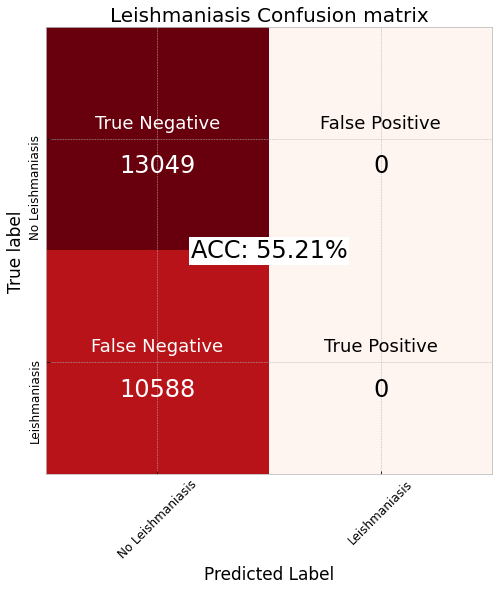

Leptospirosis
55.57%
0.0000


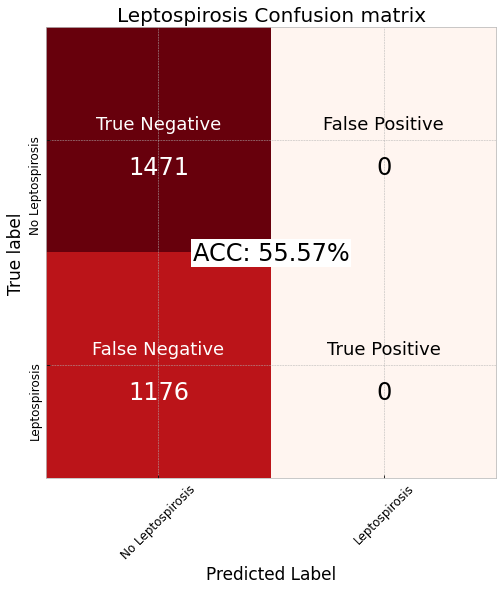

Salmonellosis
51.46%
0.0000


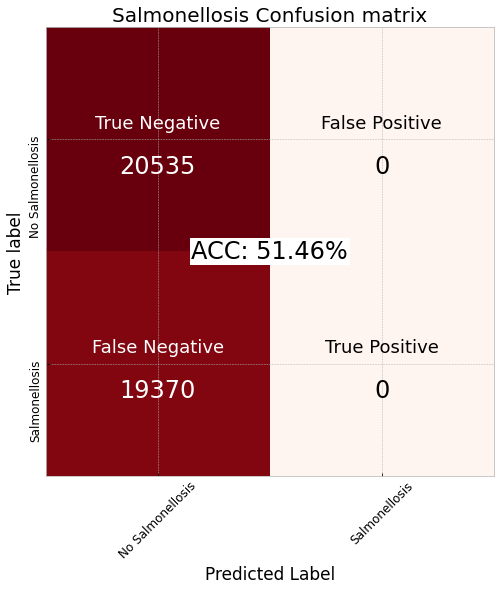

Hepatitis
52.30%
0.0000


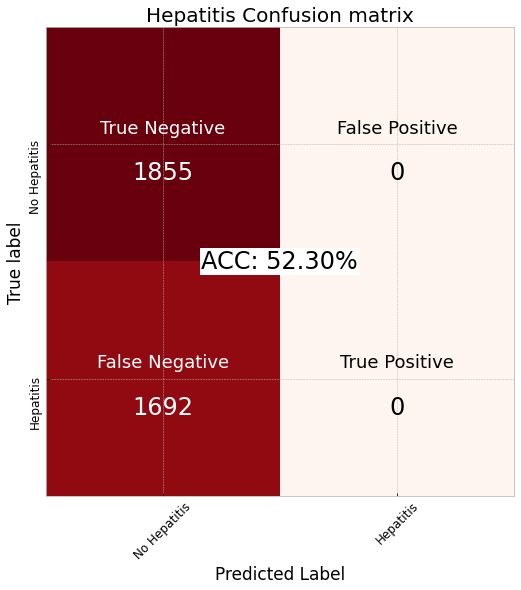

In [56]:
baselines_accuracy={}
baselines_f1score={}

for label, df in train_test_dfs.items():
    y_test= train_test_dfs[label]['y_test']
    # Make naive baseline and evaluate metrics
    baseline_pred = [0 for _ in range(len(y_test))]
    acc, f1score= calc_metrics(baseline_pred, y_test)
    baselines_accuracy[label]=acc
    baselines_f1score[label]=f1_score
    print(label)
    print(acc)
    print(f1score)
    cm = confusion_matrix(y_test, baseline_pred)
    plot_confusion_matrix(cm, 
                          classes = ['No '+label, label], 
                          title=label+' Confusion matrix', 
                          center_text=('ACC: '+acc),
                          filename= 'images/models/'+extra_label_file_name+label+'_baseline_cm_.png')

# Logistics Regression

In [57]:
# Create the model
log_reg_models={}
for label, train_test in train_test_dfs.items():
    X_train=train_test['X_train']
    y_train=train_test['y_train']
    model = LogisticRegressionCV(Cs=10, cv = 3, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42)
    #model =LogisticRegressionCV(Cs= 20, cv = 3, scoring = 'f1', 
    #                          penalty = 'elasticnet', random_state = 42,
    #                         solver='saga', l1_ratios=[0.5])
    
    model.fit(X_train, y_train)
    log_reg_models[label]=model

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.1s finished


LogisticRegressionCV(cv=3, n_jobs=-1, random_state=42, scoring='roc_auc',
                     verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished
C:\ProgramData\Anaconda3\envs\pyt3_8\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegressionCV(cv=3, n_jobs=-1, random_state=42, scoring='roc_auc',
                     verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.6s finished


LogisticRegressionCV(cv=3, n_jobs=-1, random_state=42, scoring='roc_auc',
                     verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
C:\ProgramData\Anaconda3\envs\pyt3_8\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegressionCV(cv=3, n_jobs=-1, random_state=42, scoring='roc_auc',
                     verbose=1)

In [58]:
for label, model in log_reg_models.items():    
    X_train=train_test_dfs[label]['X_train']
    coef_table = pd.DataFrame(list(X_train.columns)).copy()
    coef_table.insert(len(coef_table.columns),"Coefs",model.coef_.transpose())
    logit= ' + '.join( ["{:.5f}".format(row['Coefs'])+'*'+row[0] for _, row in coef_table.iterrows()])
    logit='logit = '+"{:.5f}".format(model.intercept_[0])+' + '+logit
    print(label)
    print(logit)
    print('')

Leishmaniasis
logit = 0.29301 + -0.11219*Superficie + -13.27286*Popolazione + 1.91324*altitudine + 22.00284*Superfici_artificiali_e_costruzioni_ha + -4.54767*Superfici_naturali_non_vegetate_ha + -2.16128*Alberi_ha + -0.08584*Arbusti_ha + -8.01678*Vegetazione_erbacea_ha + -0.74053*Acque_e_zone_umide_ha + -1.23352*Superfici_artificiali_e_costruzioni_% + 0.12754*Superfici_naturali_non_vegetate_% + -0.68995*Alberi_% + 0.75391*Arbusti_% + 0.06089*Vegetazione_erbacea_% + -1.25987*Acque_e_zone_umide_% + 1.74802*min_dist + -0.00913*count_water_sources

Leptospirosis
logit = 14.04615 + -2.70058*Superficie + -9.29915*Popolazione + -1.46362*altitudine + 16.41259*Superfici_artificiali_e_costruzioni_ha + 7.02136*Superfici_naturali_non_vegetate_ha + -3.81218*Alberi_ha + -7.29968*Arbusti_ha + -2.28345*Vegetazione_erbacea_ha + 2.94645*Acque_e_zone_umide_ha + -14.36861*Superfici_artificiali_e_costruzioni_% + -4.14730*Superfici_naturali_non_vegetate_% + -11.98469*Alberi_% + -9.93640*Arbusti_% + -9.49979

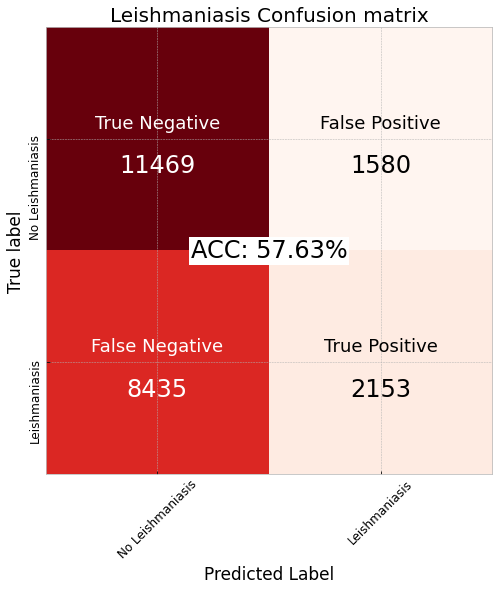

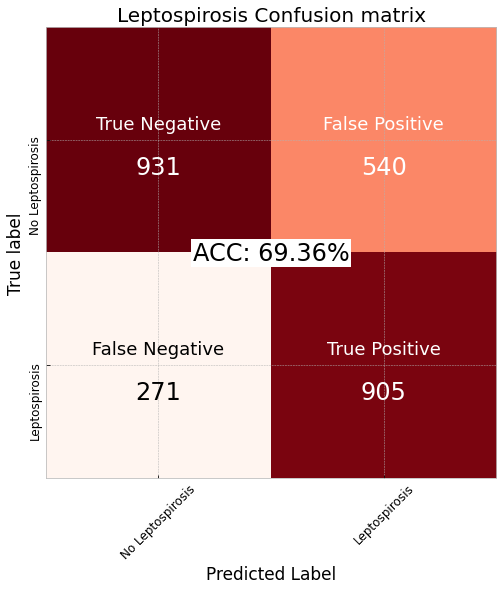

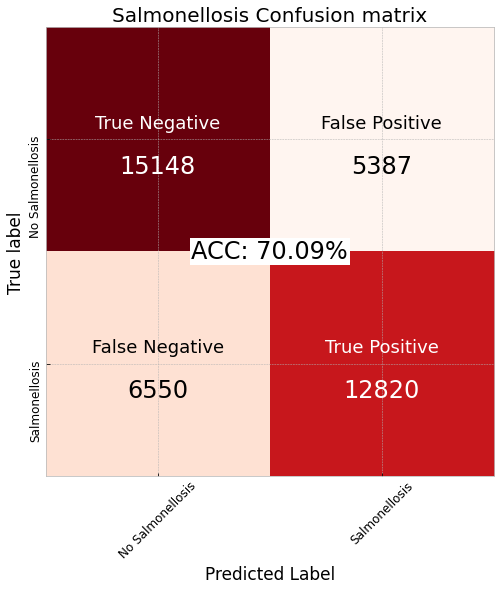

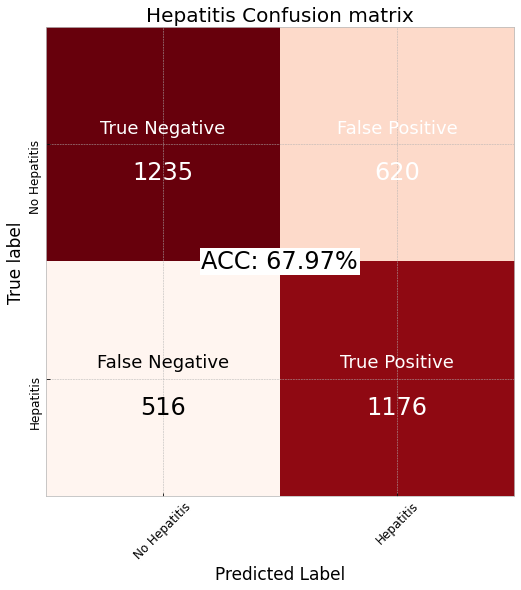

,roc_auc,f1_value,acc,baseline
Leishmaniasis,0.5895,0.3007,57.63%,55.21%
Leptospirosis,0.7574,0.6906,69.36%,55.57%
Salmonellosis,0.7380,0.6823,70.09%,51.46%
Hepatitis,0.7383,0.6743,67.97%,52.30%


In [59]:
from sklearn.metrics import f1_score, roc_auc_score

log_reg_metrics={}
log_reg_results={}
for label, model in log_reg_models.items(): 
    X_test=train_test_dfs[label]['X_test']
    y_test=train_test_dfs[label]['y_test']
    # Predictions and probabilities
    
    # Exponentiate the log odds
    #odds_ratio = np.exp(log_odds)
    # Calculate the probabilitiy
    #probability = odds_ratio / (1 + odds_ratio)
    
    zoo_results={}
    predictions = model.predict(X_test)
    zoo_results['predictions']=predictions
    probabilities = model.predict_proba(X_test)[:, 1]
    zoo_results['probabilities']=probabilities
    log_odds=model.decision_function(X_test)
    zoo_results['log_odds'] = log_odds
    zoo_results['y_test']=y_test
    log_reg_results[label]=zoo_results
    
    roc_auc = roc_auc_score(y_test, probabilities)
    f1_value = f1_score(y_test, predictions)
    accuracy = np.mean(predictions == y_test)


    zoo_metrics={}
    zoo_metrics['roc_auc']=f'{roc_auc:.4f}'
    zoo_metrics['f1_value']=f'{f1_value:.4f}'
    zoo_metrics['acc']=f'{100 * accuracy:.2f}%'
    zoo_metrics['baseline']=baselines_accuracy[label]
    log_reg_metrics[label]=zoo_metrics
    
    cm = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cm, classes = ['No '+label, label], 
                          title=label+' Confusion matrix', 
                          center_text=('ACC: '+zoo_metrics['acc']),
                          filename='images/models/'+extra_label_file_name+label+'_log_reg_cm_.png')
pd.DataFrame( log_reg_metrics).transpose()
    

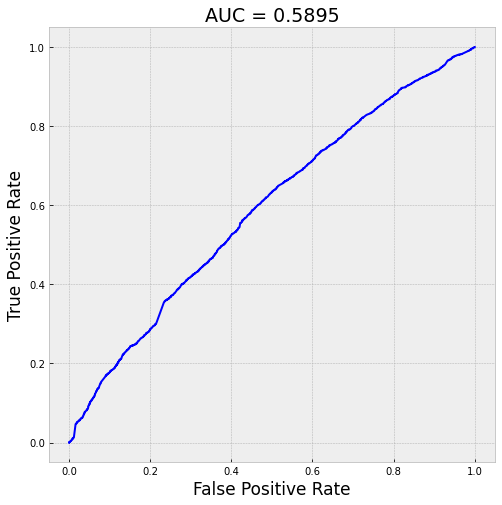

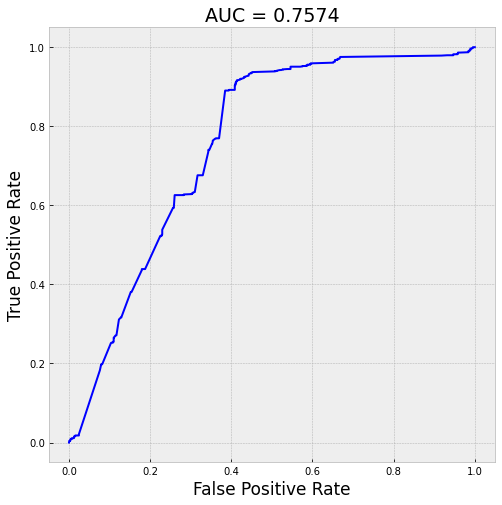

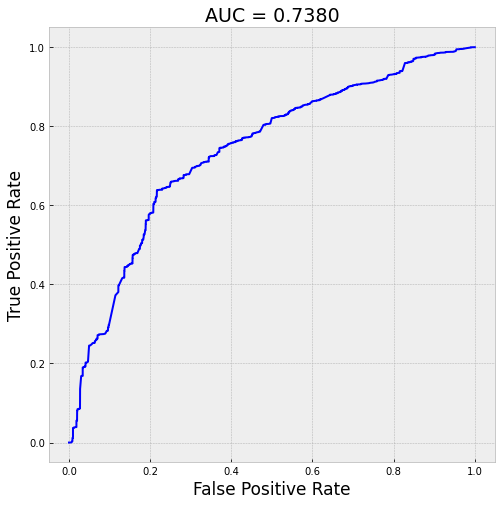

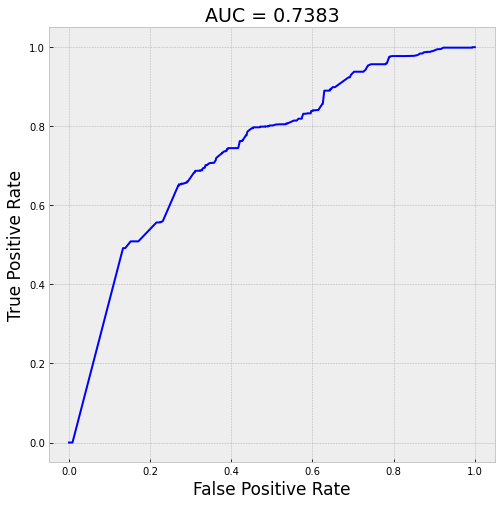

In [60]:
for label, model in log_reg_models.items(): 
    y_test=train_test_dfs[label]['y_test']
    probabilities=log_reg_results[label]['probabilities']
    calc_roc(probabilities, y_test,filename='images/models/'+extra_label_file_name+label+'_log_reg_roc_.png' )

# Model output

In [61]:
for label, result in log_reg_results.items():
    print(label)
    output=pd.DataFrame(dict(probability=result['probabilities'], 
                      log_odds=result['log_odds'], 
                      y_test=np.array(result['y_test'].astype(str)),
                      classes=result['predictions']       
                            ))
    output_desc=output.describe()
    output_desc.style.format('{:.2f}')
    output['classes']=output['classes'].astype(str)
    output.sample(1000).iplot(x='log_odds', y='probability',
                              yTitle='Probability', 
                              #xrange=(-5, 5),
                              xrange=(-10, 10),
                              xTitle='Log Odds',
                              title='Probability vs Log Odds', 
                              #categories='y_test'
                              categories='classes'
                             )


Leishmaniasis


,probability,log_odds,classes
count,23637.00,23637.00,23637.00
mean,0.44,-0.24,0.16
std,0.08,0.32,0.36
min,0.01,-4.29,0.00
25%,0.40,-0.42,0.00
50%,0.43,-0.29,0.00
75%,0.47,-0.12,0.00
max,0.88,1.96,1.00


C:\ProgramData\Anaconda3\envs\pyt3_8\lib\site-packages\cufflinks\plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\ProgramData\Anaconda3\envs\pyt3_8\lib\site-packages\cufflinks\plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



Leptospirosis


,probability,log_odds,classes
count,2647.00,2647.00,2647.00
mean,0.46,-0.35,0.55
std,0.24,1.37,0.50
min,0.00,-8.25,0.00
25%,0.23,-1.21,0.00
50%,0.54,0.16,1.00
75%,0.66,0.66,1.00
max,0.93,2.63,1.00


Salmonellosis


,probability,log_odds,classes
count,39905.00,39905.00,39905.00
mean,0.49,-0.06,0.46
std,0.20,0.93,0.50
min,0.01,-5.16,0.00
25%,0.32,-0.77,0.00
50%,0.46,-0.16,0.00
75%,0.69,0.79,1.00
max,1.00,6.75,1.00


Hepatitis


,probability,log_odds,classes
count,3547.00,3547.00,3547.00
mean,0.47,-0.27,0.51
std,0.20,1.28,0.50
min,0.00,-12.08,0.00
25%,0.30,-0.84,0.00
50%,0.51,0.03,1.00
75%,0.67,0.71,1.00
max,0.97,3.38,1.00


# Random Forest

In [62]:
# Create the model
ran_for_models={}
for label, train_test in train_test_dfs.items():
    X_train=train_test['X_train']
    y_train=train_test['y_train']
    model = RandomForestClassifier()
    _=model.fit(X_train, y_train)
    
    ran_for_models[label]=model

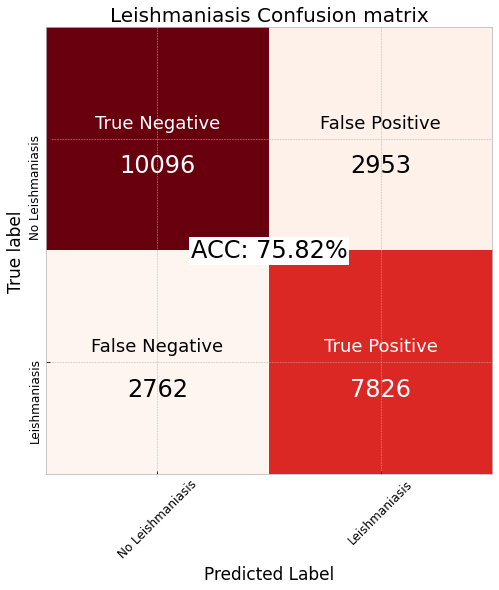

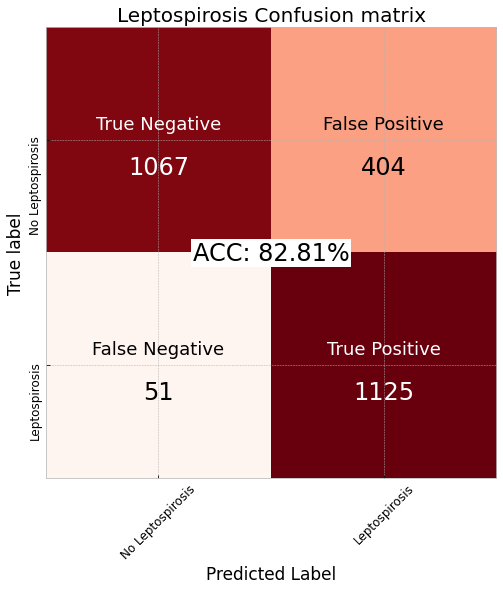

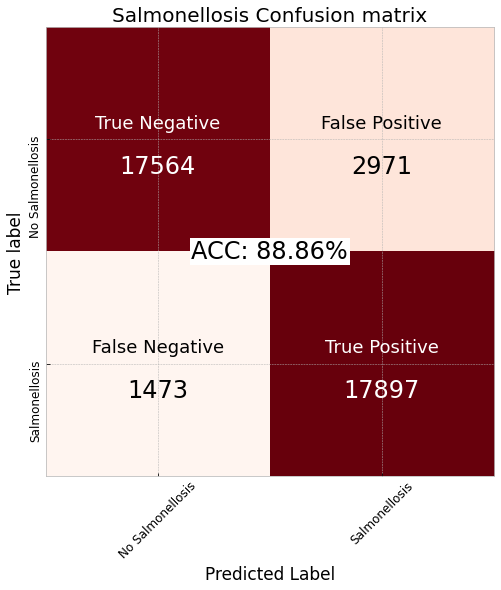

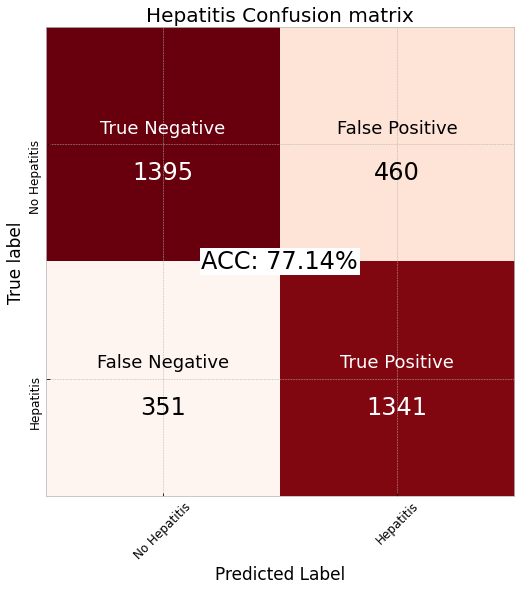

,roc_auc,f1_value,acc,baseline
Leishmaniasis,0.8487,0.7325,75.82%,55.21%
Leptospirosis,0.8894,0.8318,82.81%,55.57%
Salmonellosis,0.9611,0.8896,88.86%,51.46%
Hepatitis,0.8463,0.7678,77.14%,52.30%


In [63]:

ran_for_metrics={}
ran_for_results={}
for label, model in ran_for_models.items(): 
    X_test=train_test_dfs[label]['X_test']
    y_test=train_test_dfs[label]['y_test']
    # Predictions and probabilities
    
    # Exponentiate the log odds
    #odds_ratio = np.exp(log_odds)
    # Calculate the probabilitiy
    #probability = odds_ratio / (1 + odds_ratio)
    
    zoo_results={}
    predictions = model.predict(X_test)
    zoo_results['predictions']=predictions
    probabilities = model.predict_proba(X_test)[:, 1]
    zoo_results['probabilities']=probabilities

    ran_for_results[label]=zoo_results
    
    roc_auc = roc_auc_score(y_test, probabilities)
    f1_value = f1_score(y_test, predictions)
    accuracy = np.mean(predictions == y_test)


    zoo_metrics={}
    zoo_metrics['roc_auc']=f'{roc_auc:.4f}'
    zoo_metrics['f1_value']=f'{f1_value:.4f}'
    zoo_metrics['acc']=f'{100 * accuracy:.2f}%'
    zoo_metrics['baseline']=baselines_accuracy[label]
    ran_for_metrics[label]=zoo_metrics
    
    cm = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cm, 
                          classes = ['No '+label, label], 
                          title=label+' Confusion matrix', 
                          center_text=('ACC: '+zoo_metrics['acc']),
                          filename='images/models/'+extra_label_file_name+label+'_ran_for_cm_.png')
    
pd.DataFrame( ran_for_metrics).transpose()

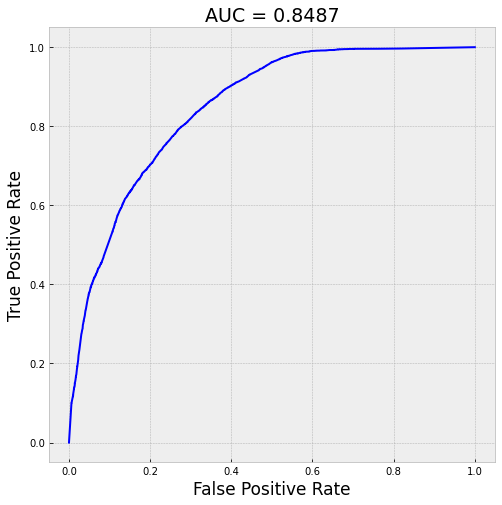

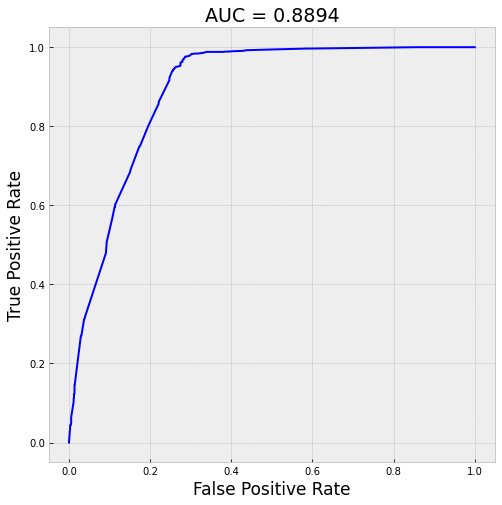

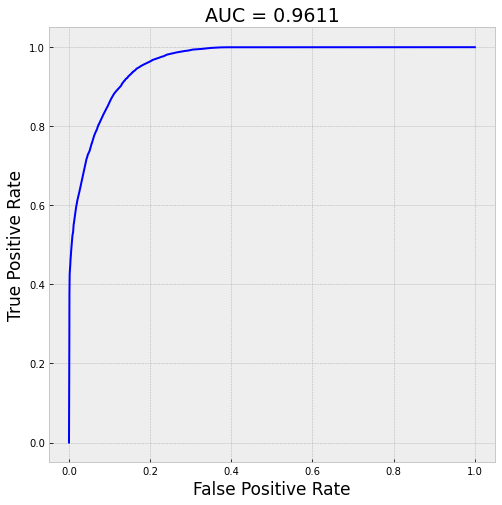

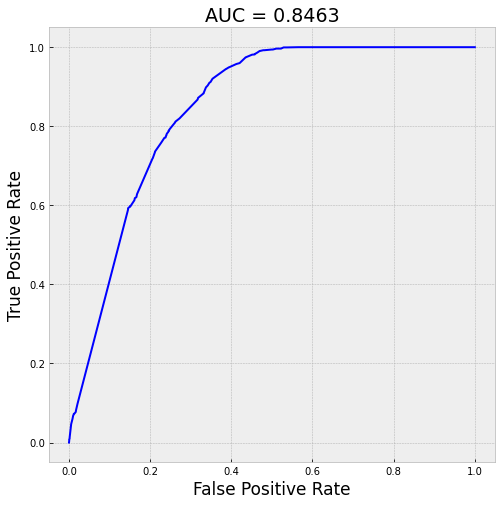

In [64]:
for label, model in ran_for_models.items(): 
    y_test=train_test_dfs[label]['y_test']
    probabilities=ran_for_results[label]['probabilities']
    calc_roc(probabilities, y_test, '', filename='images/models/'+extra_label_file_name+label+'_ran_for_roc_.png')

# Visualization


In [65]:
#import the geo dataset and preprocess it
filter_fields=['id comune',
                           'Superficie', 'Popolazione','altitudine','Superfici artificiali e costruzioni (ha)',
                           'Superfici naturali non vegetate (ha)', 'Alberi (ha)', 'Arbusti (ha)',
                           'Vegetazione erbacea (ha)', 'Acque e zone umide (ha)',
                           'Superfici artificiali e costruzioni (%)','Superfici naturali non vegetate (%)', 
                           'Alberi (%)', 'Arbusti (%)','Vegetazione erbacea (%)', 'Acque e zone umide (%)'
                            ]

dataframe_towns_geodata_all=feather.read_feather('dataframe_towns_geodata')
dataframe_towns_geodata=dataframe_towns_geodata_all[filter_fields]
dataframe_towns_geodata.columns=dataframe_towns_geodata.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
dataframe_towns_geodata_all['id comune']=dataframe_towns_geodata_all['id comune'].astype(str)
# check infinites values
count = np.isinf(dataframe_towns_geodata).values.sum()
print("It contains " + str(count) + " infinite values")

# check nan by columns
missing_towns=set()
for col in dataframe_towns_geodata.columns:
      missing_towns.update(dataframe_towns_geodata[dataframe_towns_geodata[col].isna()]['id_comune'].tolist())
     

#remove the towns with missing cover data from the dataset
dataframe_towns_geodata_nonan=dataframe_towns_geodata[~dataframe_towns_geodata['id_comune'].isin(missing_towns)]
towns_ids= dataframe_towns_geodata_nonan['id_comune'].to_list()
X_predict = dataframe_towns_geodata_nonan.drop(columns='id_comune')

#X_predict.replace([np.inf, -np.inf], np.nan, inplace=True)
#X_predict = X_predict.values.astype(np.float)


It contains 0 infinite values


C:\Users\manue\AppData\Local\Temp\ipykernel_2156\954388273.py:12: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [66]:
# predict the probabilities for all the italian municipalities
#zoonoose='Salmonellosis'
zoonoose='Leptospirosis'
#zoonoose='Leishmaniasis'
#zoonoose='Hepatitis'
model= ran_for_models[zoonoose]
model= log_reg_models[zoonoose]
probabilities=model.predict_proba(X_predict)[:, 1]


# create a dataframe with the probabilities in output from the model and the relative town codes
df_municipality_probs=pd.DataFrame({'id_comune':towns_ids, 'Pos_probability':probabilities})
df_municipality_probs['id_comune']=df_municipality_probs['id_comune'].astype(str)


# enrich the dataset with the geo features referred by id_comune
df_municipality_probs_w_geodata=df_municipality_probs.merge(dataframe_towns_geodata_all, left_on='id_comune', right_on='id comune', how='left')
df_municipality_probs_w_geodata.drop(['SHAPE_LENG', 'Shape_Le_1', 'Shape_Area','id comune'], axis='columns', inplace=True)

#enrich the dataframe with historical data of total observations and total positives observed by town
hist_observations_by_towns=datatasets[zoonoose][['COD_ISTAT_COMUNE_PRELIEVO','ESITO']].groupby('COD_ISTAT_COMUNE_PRELIEVO')['ESITO'].agg(Recorded_Positives='sum', Recorded_Observations='count')
df_municipality_probs_w_geodata_w_histObservations=df_municipality_probs_w_geodata.merge(hist_observations_by_towns, left_on='id_comune', right_on='COD_ISTAT_COMUNE_PRELIEVO', how='left')
df_municipality_probs_w_geodata_w_histObservations['Recorded_Positives']=df_municipality_probs_w_geodata_w_histObservations['Recorded_Positives'].fillna(0)
df_municipality_probs_w_geodata_w_histObservations['Recorded_Observations']=df_municipality_probs_w_geodata_w_histObservations['Recorded_Observations'].fillna(0)

with urlopen('https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_municipalities.geojson') as response:
    countries = json.load(response)

fig = px.choropleth(df_municipality_probs_w_geodata_w_histObservations, 
                    geojson=countries, 
                    locations='id_comune', 
                    color='Pos_probability',
                    color_continuous_scale="Viridis_r",
                    range_color=(0, df_municipality_probs_w_geodata_w_histObservations['Pos_probability'].max()),
                    featureidkey='properties.com_istat_code_num',
                    #scope="europe",
                    #Superfici artificiali e costruzioni (ha),Superfici naturali non vegetate (ha),Alberi (ha)	Arbusti (ha),Vegetazione erbacea (ha),Acque e zone umide (ha),Superfici artificiali e costruzioni (%),Superfici naturali non vegetate (%),Alberi (%),Arbusti (%),Vegetazione erbacea (%),Acque e zone umide (%)
                    hover_name="Nome Comune",
                    hover_data={"id_comune":True,
                                'Pos_probability':':.2%', 
                                'Recorded_Positives':True, 
                                'Recorded_Observations':True, 
                                'Nome Regione':True, 
                                'Provincia':True, 
                                'Superficie':':2f', 
                                'altitudine':':2f', 
                                'Popolazione':':2f'},
                    labels={'id_comune':'cod istat', 
                            'Pos_probability':'Probabilità evento',
                            'Recorded_Positives':'Positivi registrati',
                            'Recorded_Observations':'#Osservazioni', 
                            'Nome Regione':'Regione',
                            'Superficie':'Kmq',
                            'altitudine':'altitudine(m)',
                             },
                    )
_=fig.update_geos(projection_type="mercator", visible=False, )
#_=fig.update_traces(showlegend=True, selector=dict(type='choropleth'))

_=fig.update_layout(
        margin={"r":0,"t":0,"l":0,"b":0},
        width = 900, height=900,
        title_text = 'title',title_x=0.5,
        geo = dict(#scope = 'europe',
                    resolution = 50,
                    lonaxis_range= [ 6.6, 18.4 ],
                    lataxis_range= [35.47, 47.25],
                    #landcolor = 'rgb(217, 217, 217)',
                    )
                   )
#fig['layout']['geo']['subunitcolor']='rgba(0,0,0,0)'
_=fig.update_traces(marker_line_width=0.01)

# add main towns names to fig
main_towns=dataframe_towns_geodata_all[dataframe_towns_geodata_all['Nome Comune'].isin(["L'Aquila", "Potenza", "Catanzaro", "Napoli", "Bologna", "Trieste", "Roma", "Genova", "Milano", "Ancona", "Campobasso", "Torino", "Bari", "Cagliari", "Palermo", "Firenze", "Trento", "Perugia", "Aosta", "Venezia"])]
_=fig.add_trace(go.Scattergeo(lon=main_towns['lng'], 
                            lat=main_towns['lat'], 
                            mode='text', 
                            text=main_towns['Nome Comune'],
                            name=' ',
                            showlegend=False,  
                            hoverinfo='skip',
                            textfont=dict(
                                family="Arial Black",
                                #size=18,                       
                                color='#8b2323'
                            )
                             ))

fig.show()


C:\ProgramData\Anaconda3\envs\pyt3_8\lib\site-packages\sklearn\base.py:493: FutureWarning:

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- count_water_sources
- min_dist




ValueError: X has 15 features, but LogisticRegressionCV is expecting 17 features as input.